# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents 17 marketing campaigns conducted by a Portuguese bank between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [118]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif

In [52]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [53]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [54]:
#Count all the missing values
missing_values_count = df.isnull().sum()
print(missing_values_count)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


#### There are no missing values!

In [55]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [56]:
#### Coerce to appropriate data types
# Convert numeric columns to numeric data types
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Convert categorical columns to category data types
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df[categorical_cols] = df[categorical_cols].apply(lambda col: col.astype('category'))

# Check the data types after coercion
print("Data types after coercion:")
print(df.dtypes)

Data types after coercion:
age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                   object
dtype: object


In [57]:
#Columns that have Unknown columns
unknown_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']
#Replacing unknown values with NA
df[unknown_cols] = df[unknown_cols].replace('unknown', pd.NA)

#Replacing the most unknowns with most common values
for col in unknown_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)  

In [58]:
#Checking for  Duplicates
duplicates = df[df.duplicated(keep=False)]

# Count the number of duplicate columns
num_duplicates = len(duplicates)

print(f'Number of duplicate columns: {num_duplicates}')


Number of duplicate columns: 28


In [59]:
#Dropping the Duplicates
df = df.drop_duplicates()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41174 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41174 non-null  int64   
 1   job             41174 non-null  category
 2   marital         41174 non-null  category
 3   education       41174 non-null  category
 4   default         41174 non-null  category
 5   housing         41174 non-null  category
 6   loan            41174 non-null  category
 7   contact         41174 non-null  category
 8   month           41174 non-null  category
 9   day_of_week     41174 non-null  category
 10  duration        41174 non-null  int64   
 11  campaign        41174 non-null  int64   
 12  pdays           41174 non-null  int64   
 13  previous        41174 non-null  int64   
 14  poutcome        41174 non-null  category
 15  emp.var.rate    41174 non-null  float64 
 16  cons.price.idx  41174 non-null  float64 
 17  cons.conf.idx   4

## Business Objective


The goal is to optimize the direct marketing campaigns of a Portuguese banking institution by leveraging historical data to predict whether a client will subscribe to a bank term deposit. The marketing campaigns are conducted via phone calls, often requiring multiple contacts with the same client. By accurately predicting the likelihood of subscription, the bank aims to improve the efficiency of its marketing efforts, reduce operational costs, and enhance customer engagement.

To achieve this, we will analyze the following types of data:

Client Demographics: Age, job type, marital status, education level, default status, housing loan status, and personal loan status.
Last Contact Information: Communication type, last contact month, last contact day of the week, and duration of the last contact.
Campaign Data: Number of contacts during the current campaign, days since the last contact from a previous campaign, number of previous contacts, and the outcome of the previous campaign.
Economic Indicators: Employment variation rate, consumer price index, consumer confidence index, Euribor 3-month rate, and the number of employees.
The target variable is whether the client subscribed to the term deposit ('yes' or 'no'). By developing a predictive model, the bank can better identify potential clients who are more likely to subscribe, thereby maximizing the return on investment for marketing campaigns and improving overall customer satisfaction.

In [61]:
# Create crosstabs for categorical variables against the target variable
job_crosstab = pd.crosstab(df['job'], df['y'], normalize='index')
marital_crosstab = pd.crosstab(df['marital'], df['y'], normalize='index')
education_crosstab = pd.crosstab(df['education'], df['y'], normalize='index')
contact_crosstab = pd.crosstab(df['contact'], df['y'], normalize='index')
month_crosstab = pd.crosstab(df['month'], df['y'], normalize='index')
day_of_week_crosstab = pd.crosstab(df['day_of_week'], df['y'], normalize='index')
poutcome_crosstab = pd.crosstab(df['poutcome'], df['y'], normalize='index')

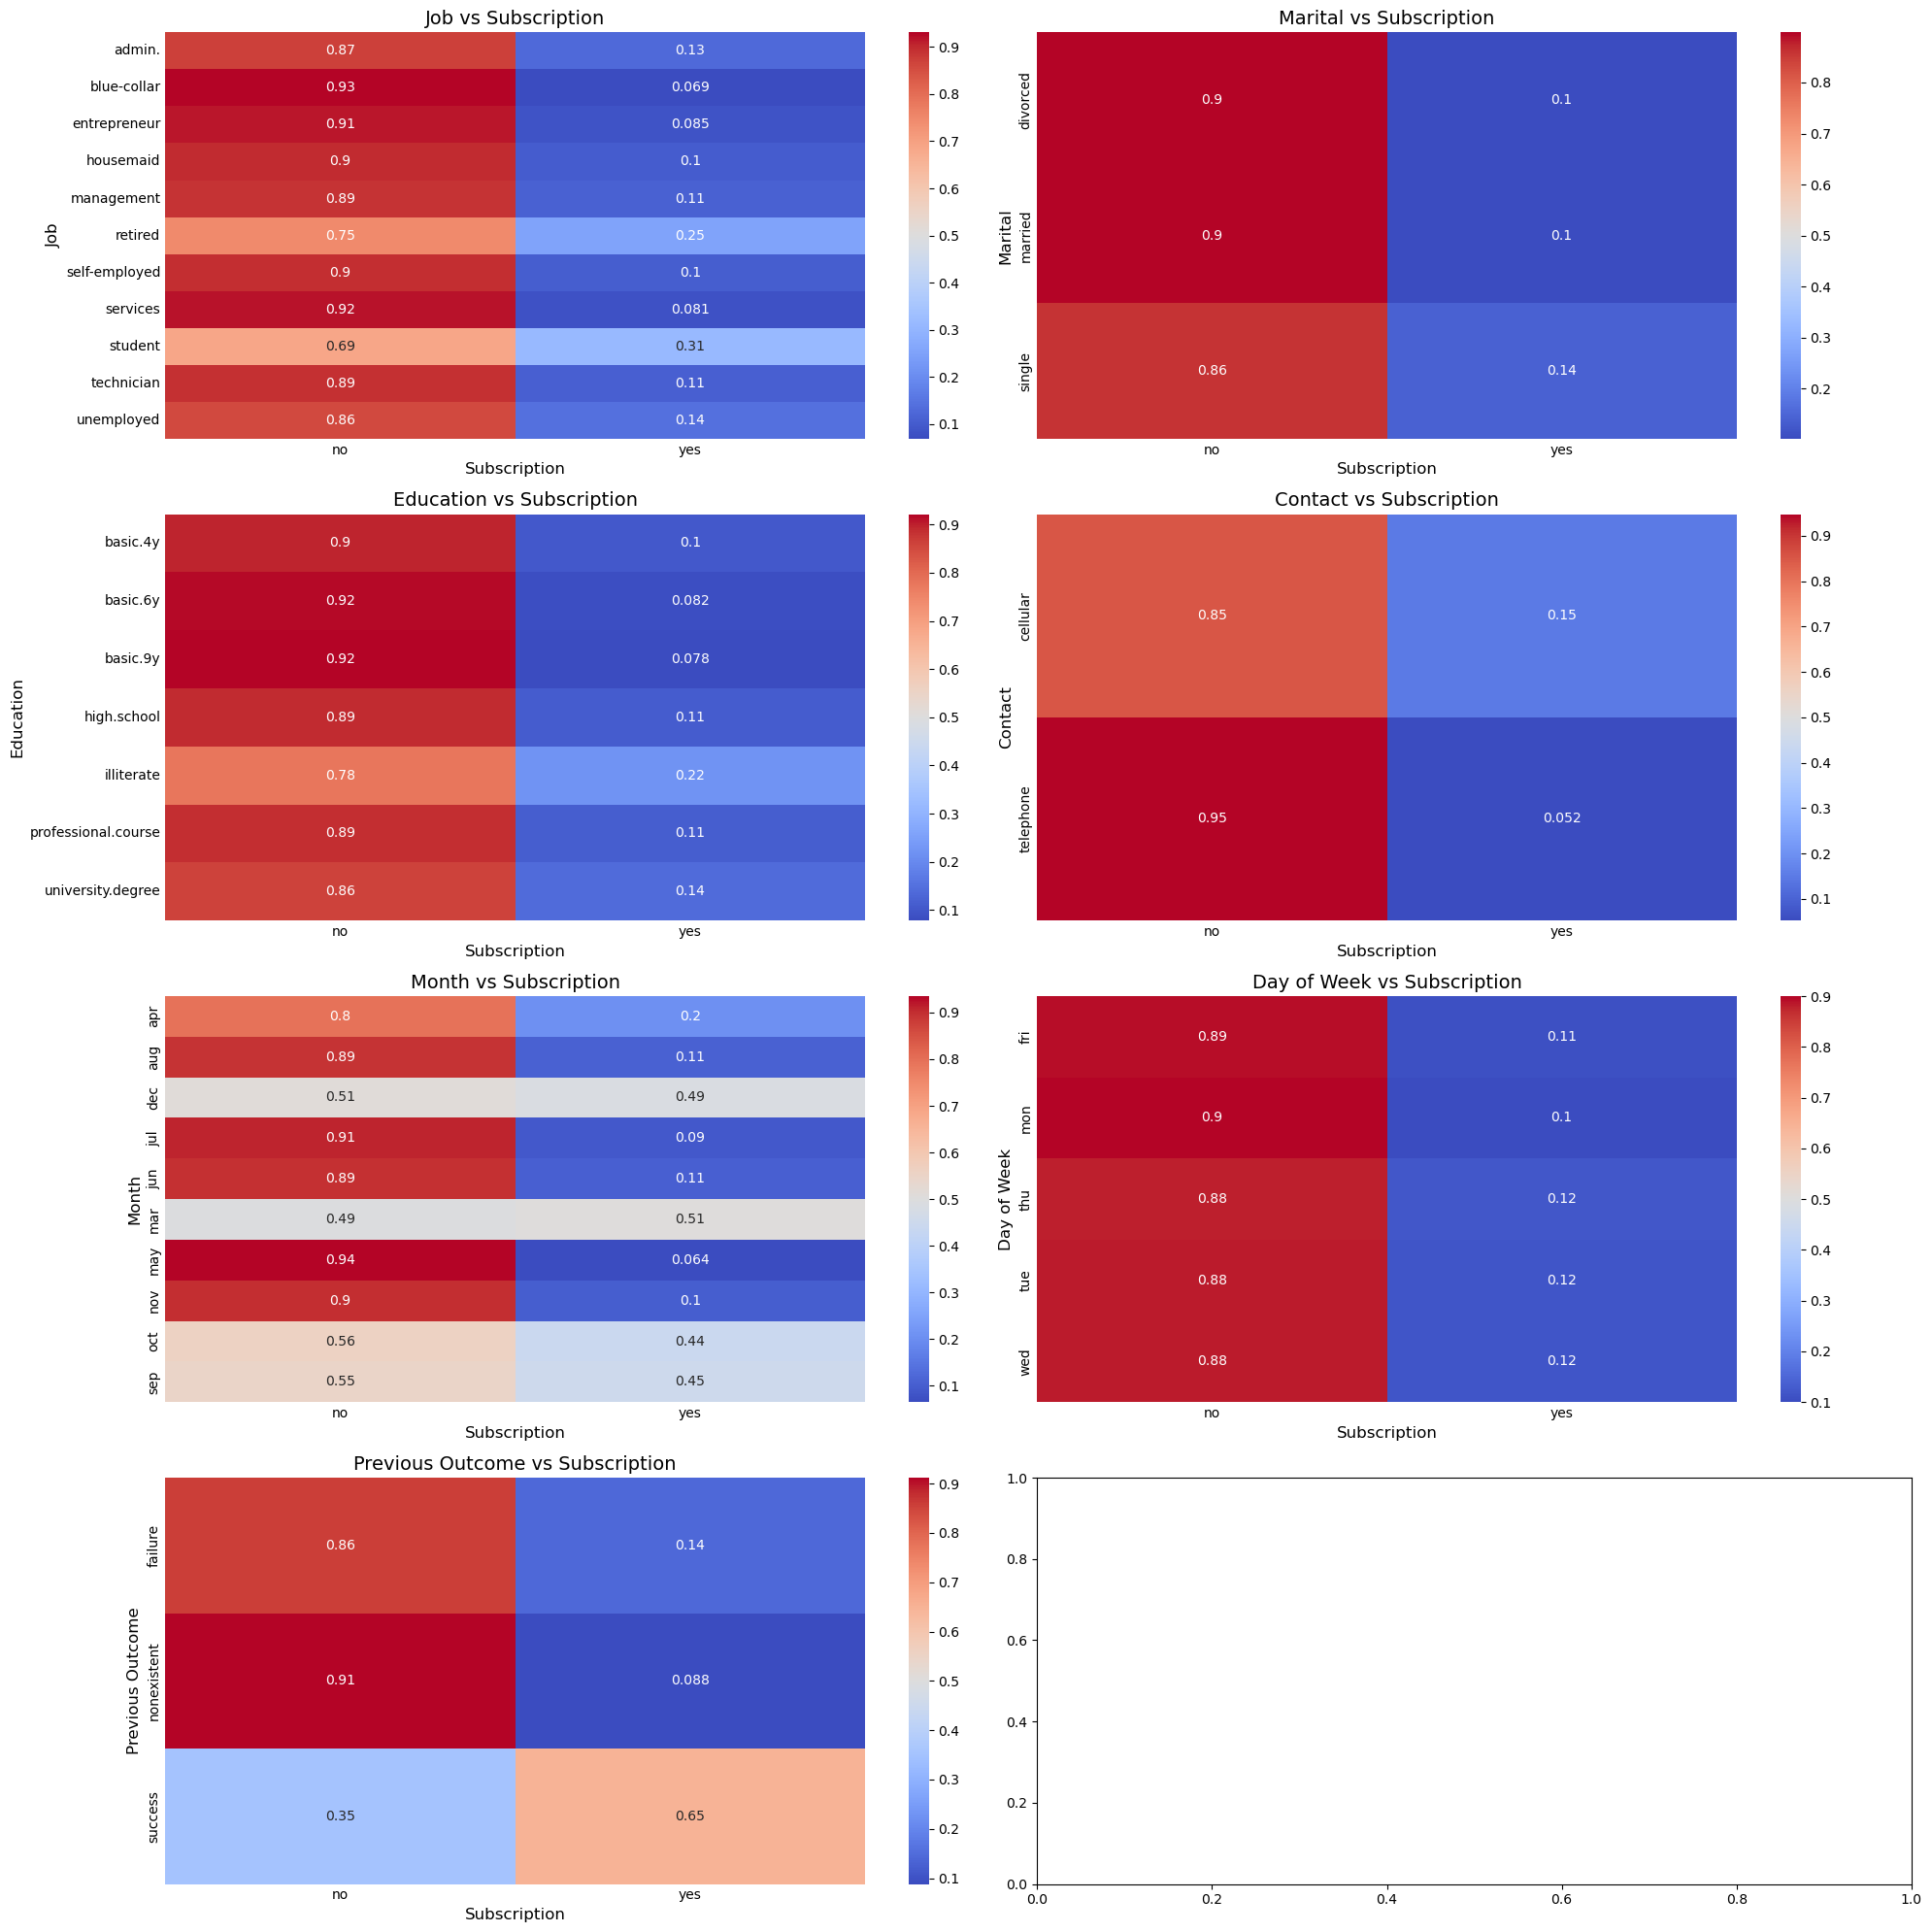

In [62]:
# Create a list of crosstabs and corresponding labels
crosstabs = [job_crosstab, marital_crosstab, education_crosstab, contact_crosstab, 
             month_crosstab, day_of_week_crosstab, poutcome_crosstab]
labels = ['Job', 'Marital', 'Education', 'Contact', 'Month', 'Day of Week', 'Previous Outcome']

# Create subplots for each crosstab
fig, axs = plt.subplots(4, 2, figsize=(20, 20))

# Flatten the axis array for easy iteration
axs = axs.flatten()

# Plot each crosstab
for i, (crosstab, label) in enumerate(zip(crosstabs, labels)):
    sns.heatmap(crosstab, annot=True, cmap='coolwarm', ax=axs[i])
    axs[i].set_title(f'{label} vs Subscription', fontsize=14)
    axs[i].set_xlabel('Subscription', fontsize=12)
    axs[i].set_ylabel(label, fontsize=12)
    axs[i].tick_params(axis='both', which='both', length=0)  # Remove ticks

plt.tight_layout()
plt.show()

### Analysis of Heatmaps:


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [63]:

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_cols)
    ])

# Encode the target variable
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['y'])

# Separate features (X) and target (y)
X = df[categorical_cols + numeric_cols]
y = df['y']

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline on the entire dataset and transform it
X_transformed = pipeline.fit_transform(X)


/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [64]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32939, 47)
X_test shape: (8235, 47)
y_train shape: (32939,)
y_test shape: (8235,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [65]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

Baseline accuracy: 0.8881


In [66]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier with strategy='most_frequent'
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the DummyClassifier on the training data
dummy_clf.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred_dummy = dummy_clf.predict(X_test)

# Calculate accuracy of the dummy classifier (baseline)
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)

print(f"Baseline accuracy (DummyClassifier): {dummy_accuracy:.4f}")

Baseline accuracy (DummyClassifier): 0.8842


### Analysis of Baseline Accuracy:

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [67]:
# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Fit the model
start_time = time.time()
log_reg.fit(X_train, y_train)
fit_time = time.time() - start_time

# Predict the target variable for the test data
y_pred_log_reg = log_reg.predict(X_test)



/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Problem 9: Score the Model

What is the accuracy of your model?

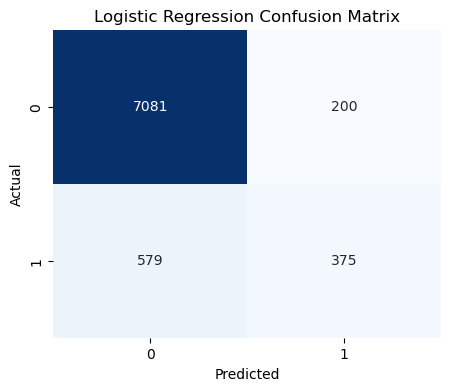

Logistic Regression:
Accuracy: 0.9054
Fit Time: 0.3263 seconds


In [68]:
# Calculate accuracy of the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

# Create confusion matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Display results
print("Logistic Regression:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Fit Time: {fit_time:.4f} seconds")

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


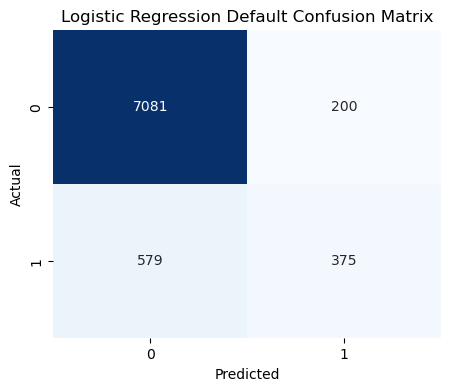

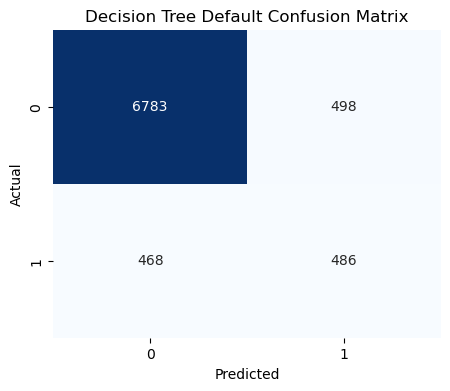

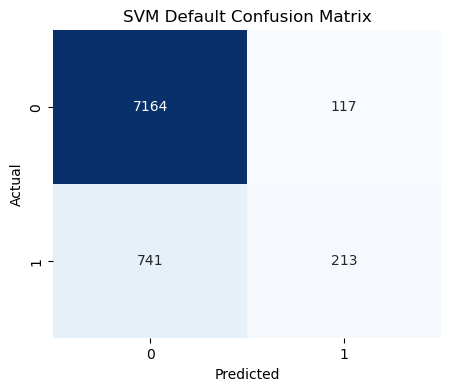

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.274744,0.910076,0.905404
1,KNN,0.002470,0.932026,0.899818
2,Decision Tree,0.135984,1.000000,0.882696
3,SVM,7.587658,0.898449,0.895811


In [120]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}

# Initialize an empty DataFrame to store results
results = pd.DataFrame(columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

# Fit and evaluate each model
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Training accuracy
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Test accuracy
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
     # Create confusion matrix for models that support it
    if model_name in ["Logistic Regression", "Decision Tree", "SVM"]:
        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model_name} Default Confusion Matrix")
        # Save plot
        plt.savefig(f'images/{model_name}_defaultconfusion.png')
        plt.show()
    else:
        cm = None
    
    # Append results to DataFrame
    results.loc[len(results)] = [model_name, fit_time, train_accuracy, test_accuracy]

# Display results DataFrame
results.head()

### Analysis of Default Models

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

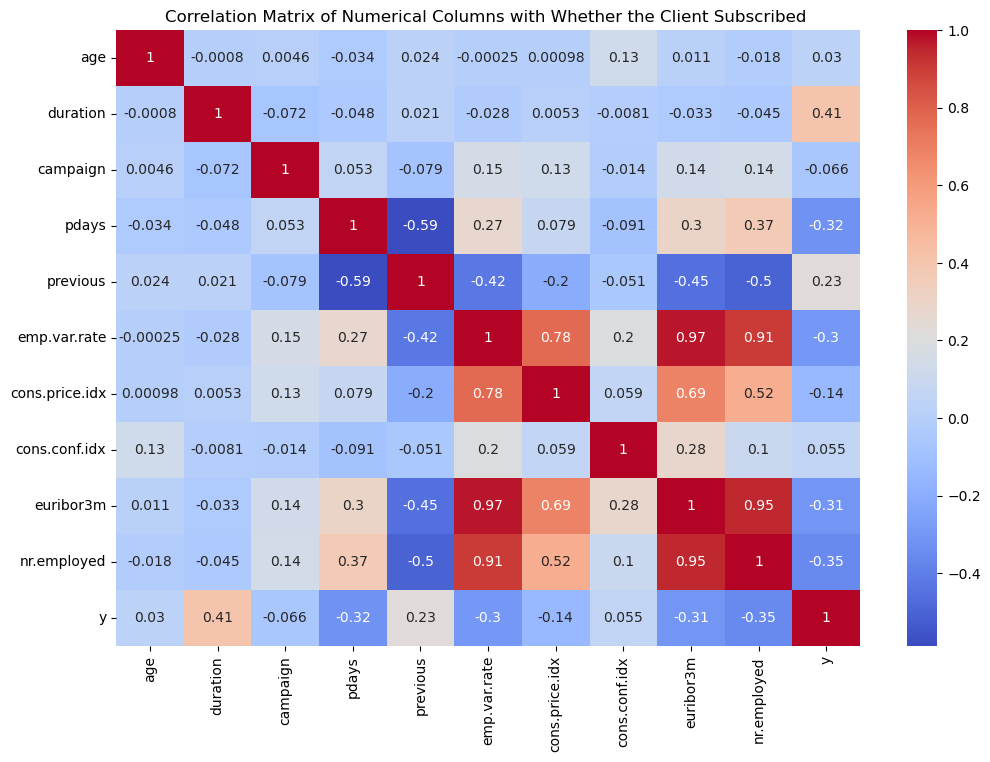

In [70]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols + ['y']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Columns with Whether the Client Subscribed ')
plt.savefig(f'images/correlationmatrix.png')
plt.show()

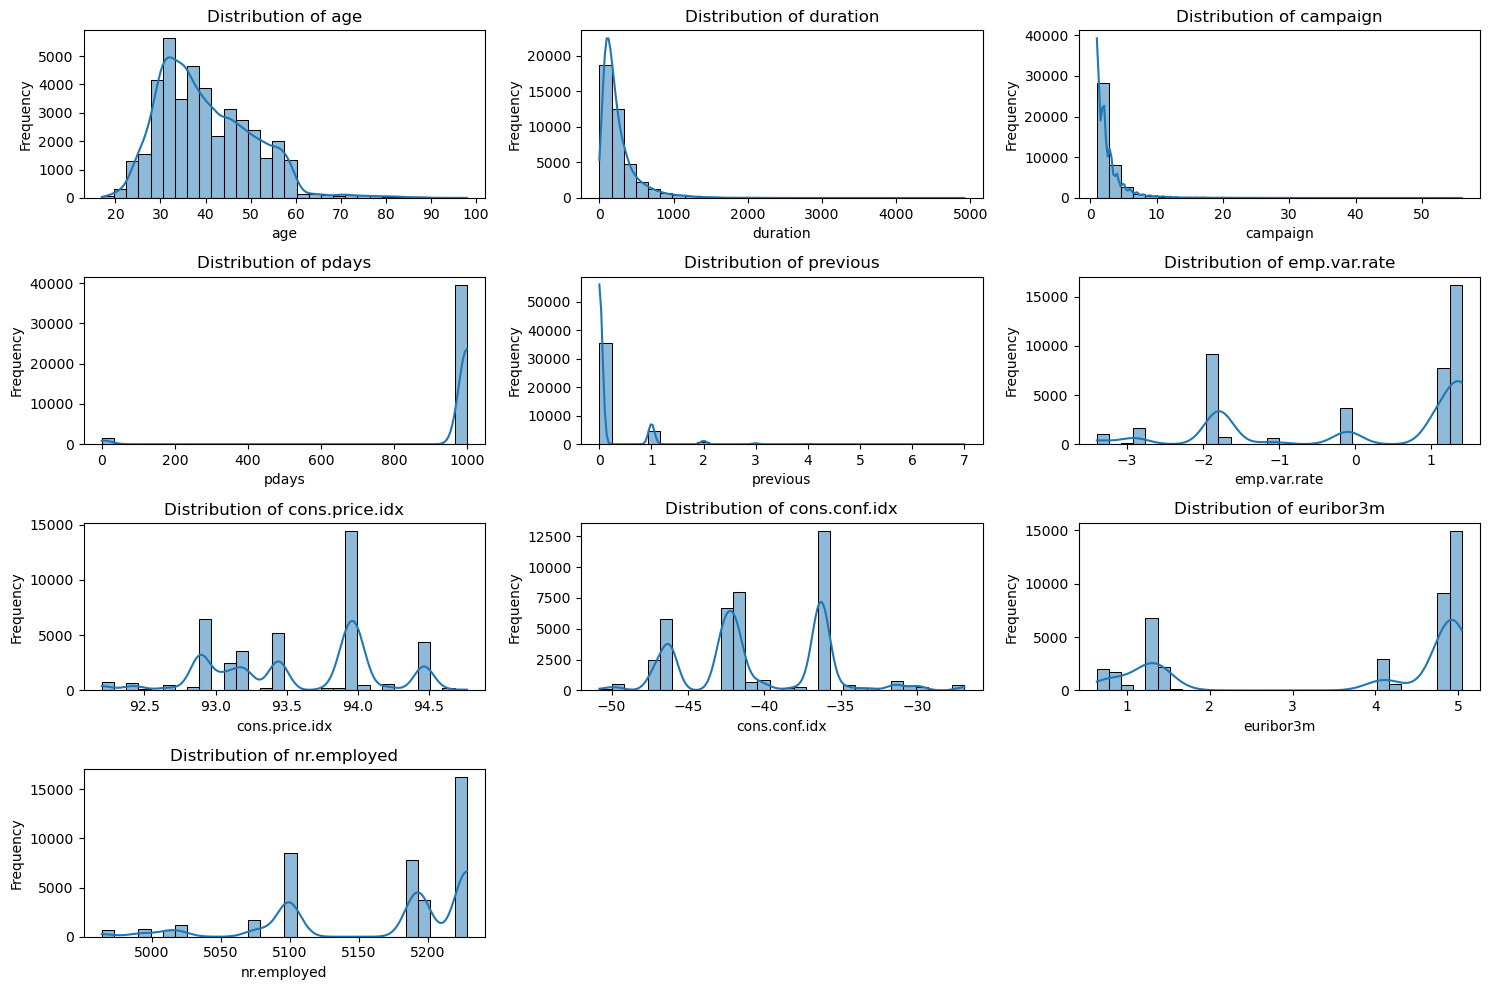

In [71]:

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

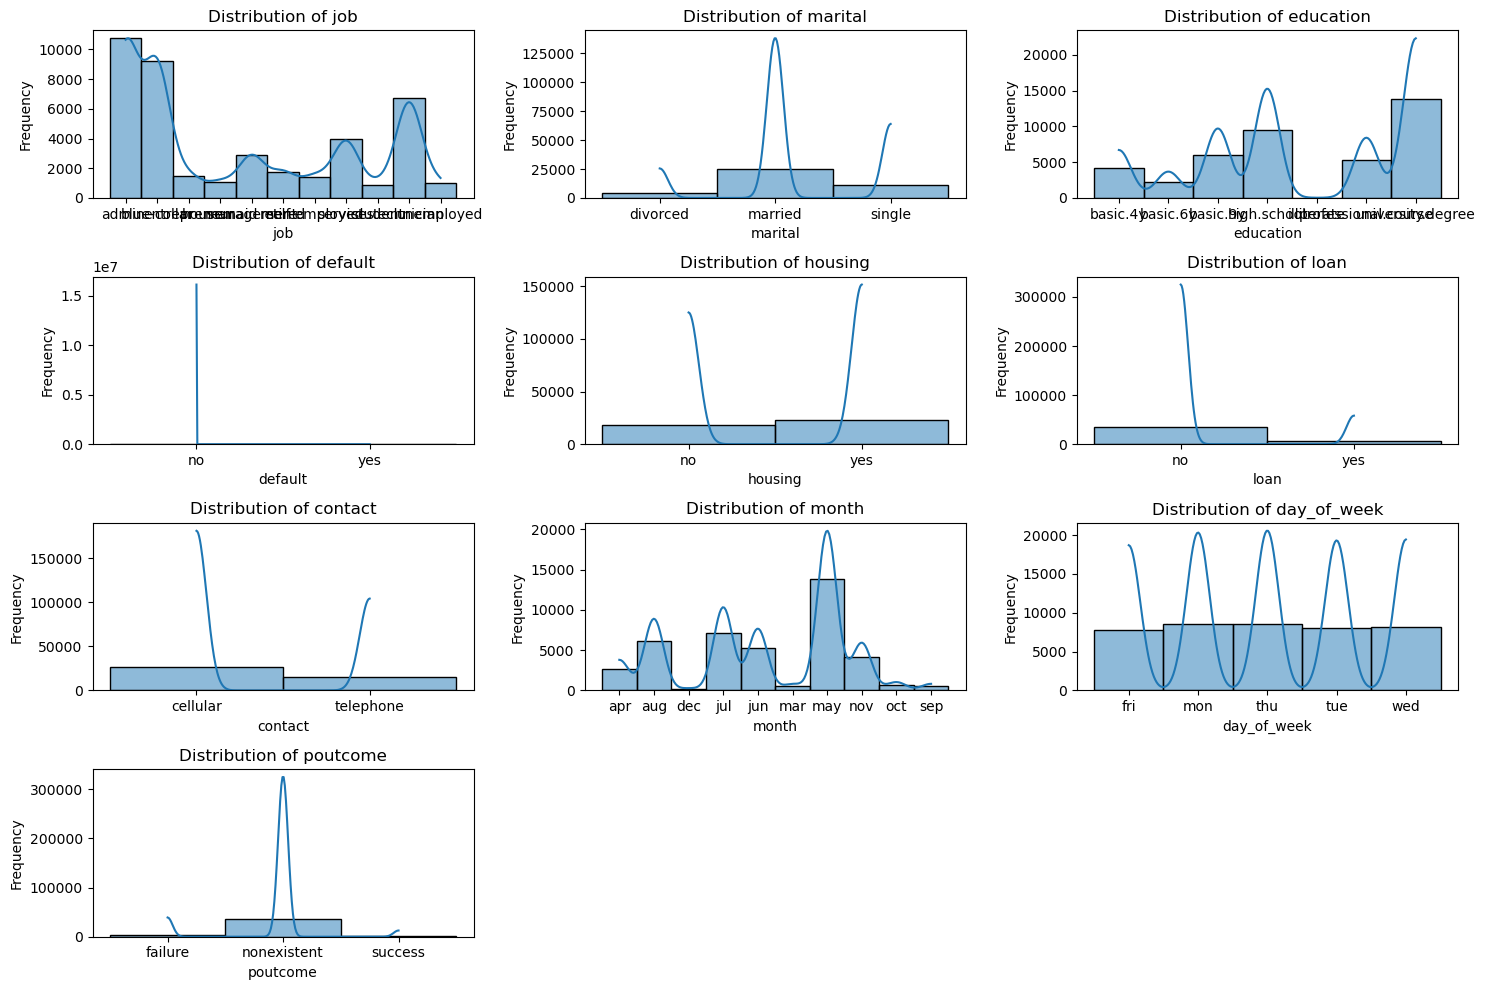

In [72]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [104]:
# Define the parameter grid for Logistic Regression
log_reg_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search with cross-validation for Logistic Regression
log_reg_grid_search = GridSearchCV(LogisticRegression(random_state=42), log_reg_param_grid, cv=5, scoring='recall')
log_reg_grid_search.fit(X_train, y_train)

# Get the best Logistic Regression model from the grid search
best_log_reg_model = log_reg_grid_search.best_estimator_
best_log_reg_model

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

LogisticRegression(C=0.1, random_state=42)

In [105]:
from sklearn.preprocessing import StandardScaler
#Improving KNN
# Define the parameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create a pipeline with scaling and KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Perform grid search with cross-validation for KNN
knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Get the best KNN model from the grid search
best_knn_model = knn_grid_search.best_estimator_
best_knn_model

python(2591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=11))])

In [75]:

# Define the parameter grid for Decision Tree
dt_param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [None, 10, 20, 50]
}

# Perform grid search with cross-validation for Decision Tree
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42), 
    dt_param_grid, 
    cv=5, 
    scoring='recall'
)
dt_grid_search.fit(X_train, y_train)

# Get the best Decision Tree model from the grid search
best_dt_model = dt_grid_search.best_estimator_
best_dt_model

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=20, random_state=42)

In [76]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for SVM
svm_param_dist = {'C': [0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto']}

# Perform randomized search with cross-validation for SVM
svm_random_search = RandomizedSearchCV(SVC(random_state=42), svm_param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
svm_random_search.fit(X_train, y_train)

# Get the best SVM model from the randomized search
best_svm_model = svm_random_search.best_estimator_
print(best_svm_model)

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVC(C=10, random_state=42)


In [106]:
# Initialize the best models
best_models = {
    "Logistic Regression": best_log_reg_model,
    "KNN": best_knn_model,
    "Decision Tree": best_dt_model,
    "SVM": best_svm_model
}
best_models

{'Logistic Regression': LogisticRegression(C=0.1, random_state=42),
 'KNN': Pipeline(steps=[('scaler', StandardScaler()),
                 ('knn',
                  KNeighborsClassifier(metric='manhattan', n_neighbors=11))]),
 'Decision Tree': DecisionTreeClassifier(max_depth=7, max_leaf_nodes=20, random_state=42),
 'SVM': SVC(C=10, random_state=42)}

In [107]:

# Initialize an empty DataFrame to store results
results_improved = pd.DataFrame(columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy"])

# Fit and evaluate each model
for model_name, model in best_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Training accuracy
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Test accuracy
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    
    # Append results to DataFrame
    results_improved.loc[len(results_improved)] = [model_name, fit_time, train_accuracy, test_accuracy]

# Display results DataFrame
results_improved.head()

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.307190,0.910471,0.905768
1,KNN,0.009330,0.909499,0.896053
2,Decision Tree,0.064597,0.918880,0.912204
3,SVM,8.343207,0.898843,0.896903


In [108]:

def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time
    
    # Training accuracy
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    
    # Test predictions and accuracy
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Classification report
    class_report = classification_report(y_test, y_pred_test, output_dict=True)
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']
    
    # ROC AUC score
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
    else:
        roc_auc = roc_auc_score(y_test, model.decision_function(X_test))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{type(model).__name__} Confusion Matrix")
    plt.show()
    
    return fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc



/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


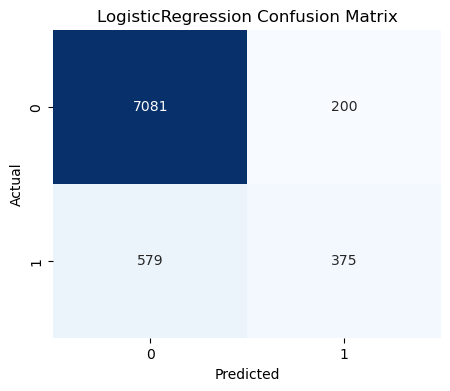

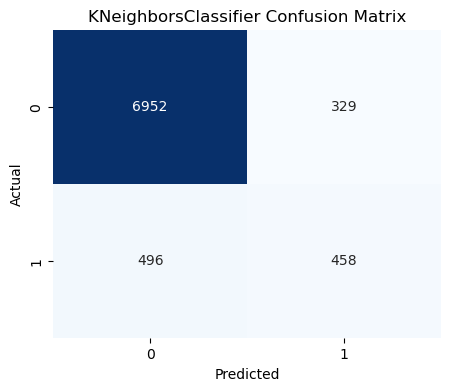

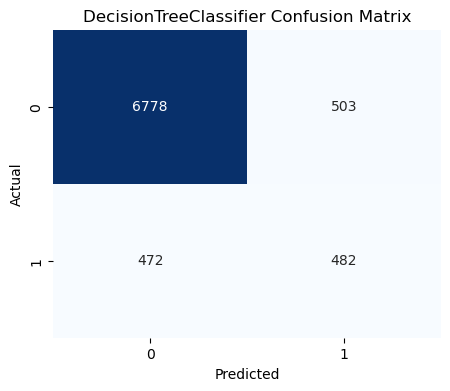

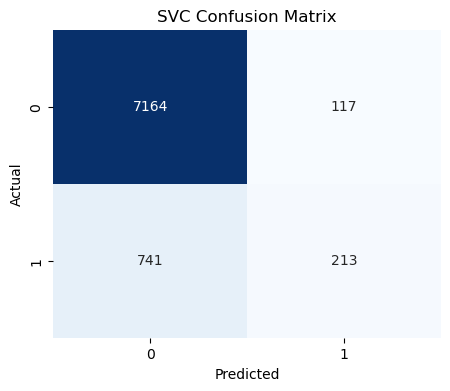

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.260835,0.910076,0.905404,0.892875,0.905404,0.894880,0.924105
1,KNN,0.002567,0.932026,0.899818,0.892691,0.899818,0.895581,0.863953
2,Decision Tree,0.140435,1.000000,0.881603,0.883280,0.881603,0.882423,0.718079
3,SVM,7.757313,0.898449,0.895811,0.876048,0.895811,0.872634,0.919281


In [111]:

results_baseline = []

for model_name, model in models.items():
    fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_train, y_train, X_test, y_test)
    results_baseline.append([model_name, fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc])

results_baseline_df = pd.DataFrame(results_baseline, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Display results DataFrame
results_baseline_df

/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


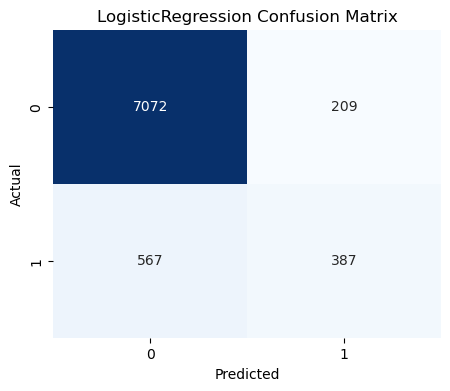

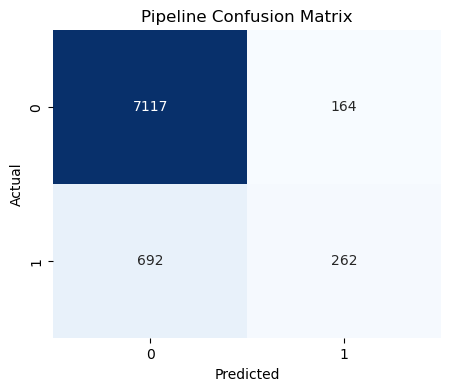

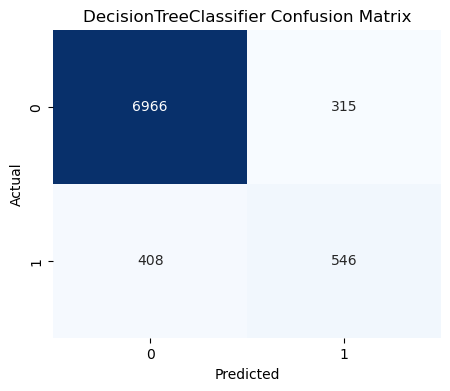

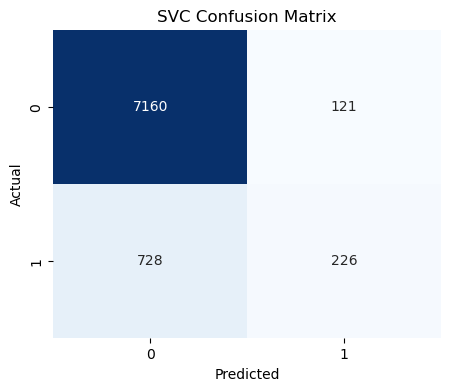

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.284250,0.910471,0.905768,0.893750,0.905768,0.896016,0.924918
1,KNN,0.025614,0.909499,0.896053,0.877052,0.896053,0.877987,0.858256
2,Decision Tree,0.062845,0.918880,0.912204,0.908697,0.912204,0.910233,0.918014
3,SVM,8.132886,0.898843,0.896903,0.878003,0.896903,0.874916,0.915714


In [95]:

results_other = []

for model_name, model in best_models.items():
    fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_train, y_train, X_test, y_test)
    results_other.append([model_name, fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc])

results_df = pd.DataFrame(results_other, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Display results DataFrame
results_df


/Users/anjanacox/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


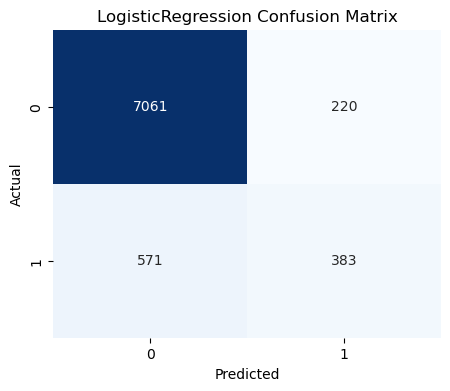

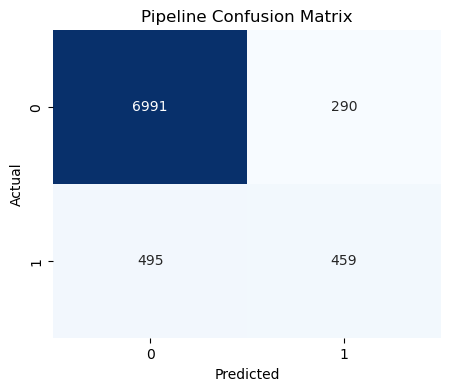

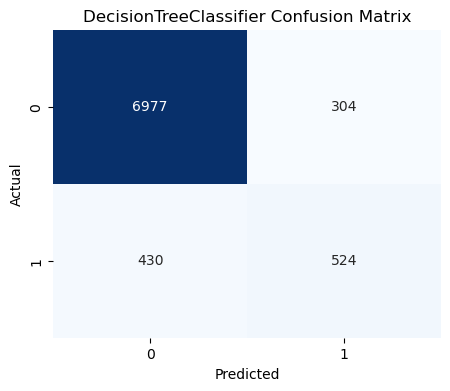

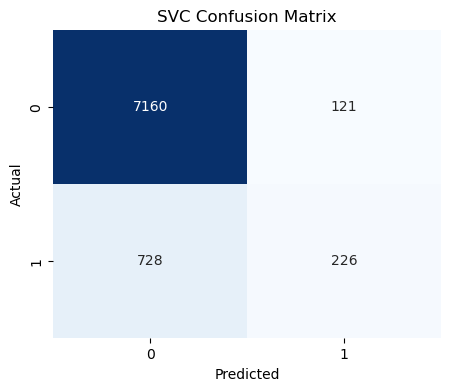

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.173655,0.910167,0.903947,0.891585,0.903947,0.894250,0.929985
1,KNN,0.010815,0.922098,0.904675,0.896683,0.904675,0.899599,0.913196
2,Decision Tree,0.035135,0.917605,0.910868,0.906139,0.910868,0.908099,0.928230
3,SVM,4.880610,0.898813,0.896903,0.878003,0.896903,0.874916,0.910890


In [96]:


# Select the top 20 features
selector = SelectKBest(f_classif, k=20)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


results_select = []

for model_name, model in best_models.items():
    fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_train_selected, y_train, X_test_selected, y_test)
    results_select.append([model_name, fit_time, train_accuracy, test_accuracy, precision, recall, f1, roc_auc])

results_select_df = pd.DataFrame(results_select, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])

# Display results DataFrame
results_select_df

/var/folders/0l/8_d97w8541g78z4w8260h88w0000gn/T/ipykernel_1093/2157598297.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='variable', y='value', hue='Tuning', data=model_data, ci=None)


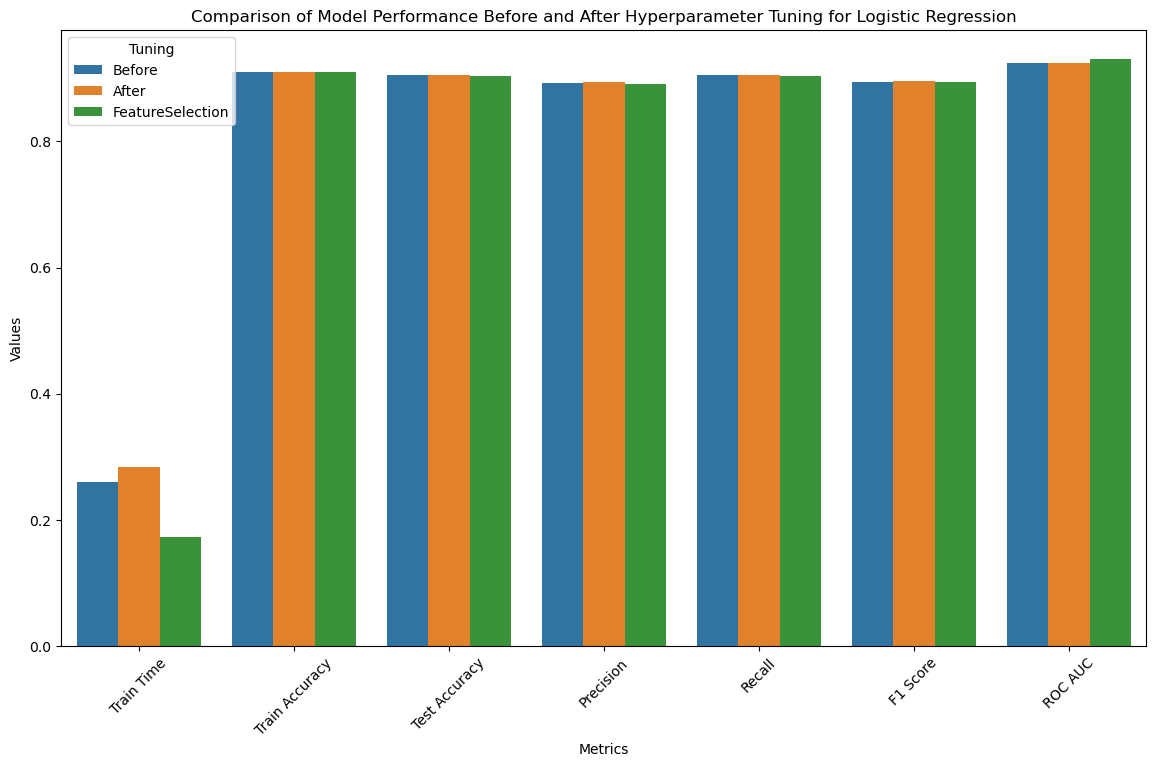

/var/folders/0l/8_d97w8541g78z4w8260h88w0000gn/T/ipykernel_1093/2157598297.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='variable', y='value', hue='Tuning', data=model_data, ci=None)


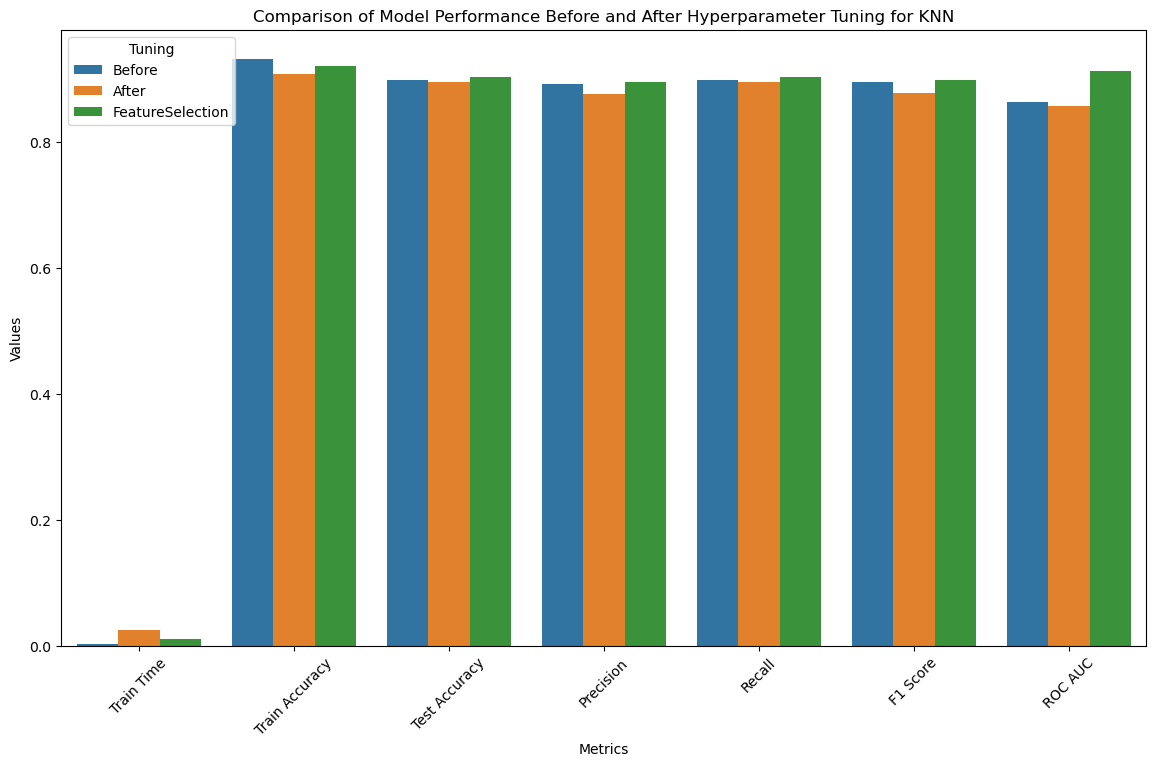

/var/folders/0l/8_d97w8541g78z4w8260h88w0000gn/T/ipykernel_1093/2157598297.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='variable', y='value', hue='Tuning', data=model_data, ci=None)


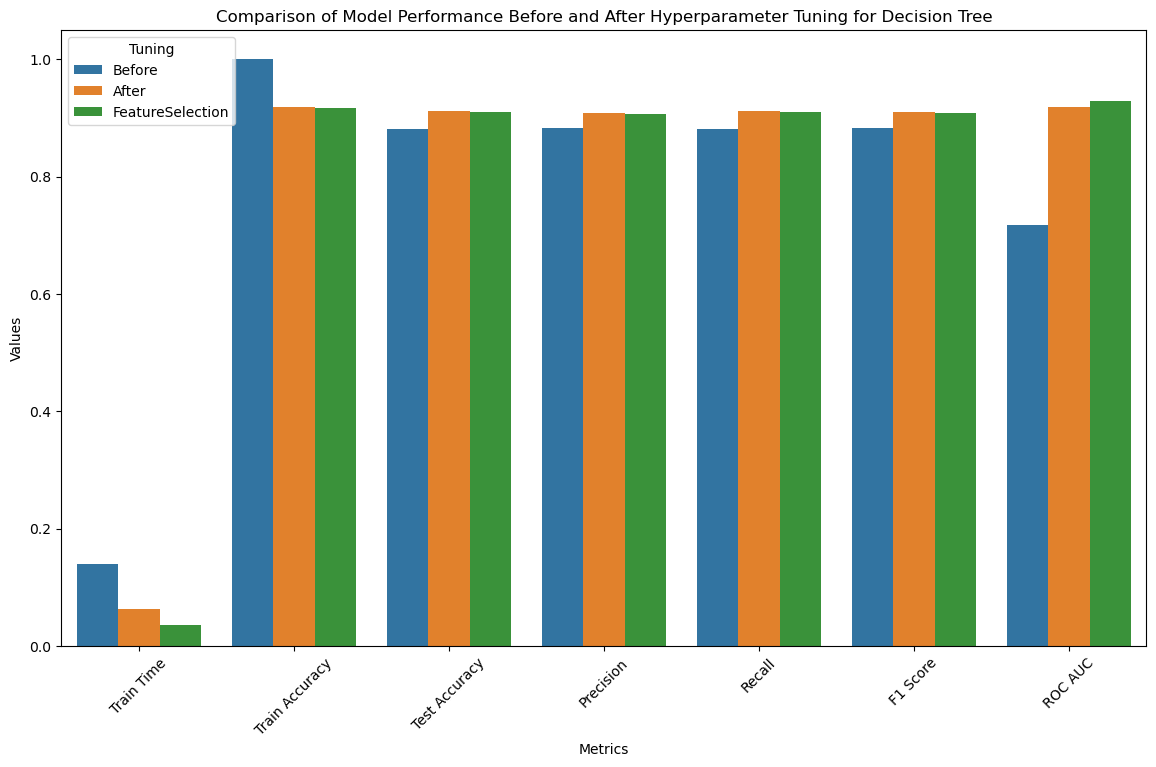

/var/folders/0l/8_d97w8541g78z4w8260h88w0000gn/T/ipykernel_1093/2157598297.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='variable', y='value', hue='Tuning', data=model_data, ci=None)


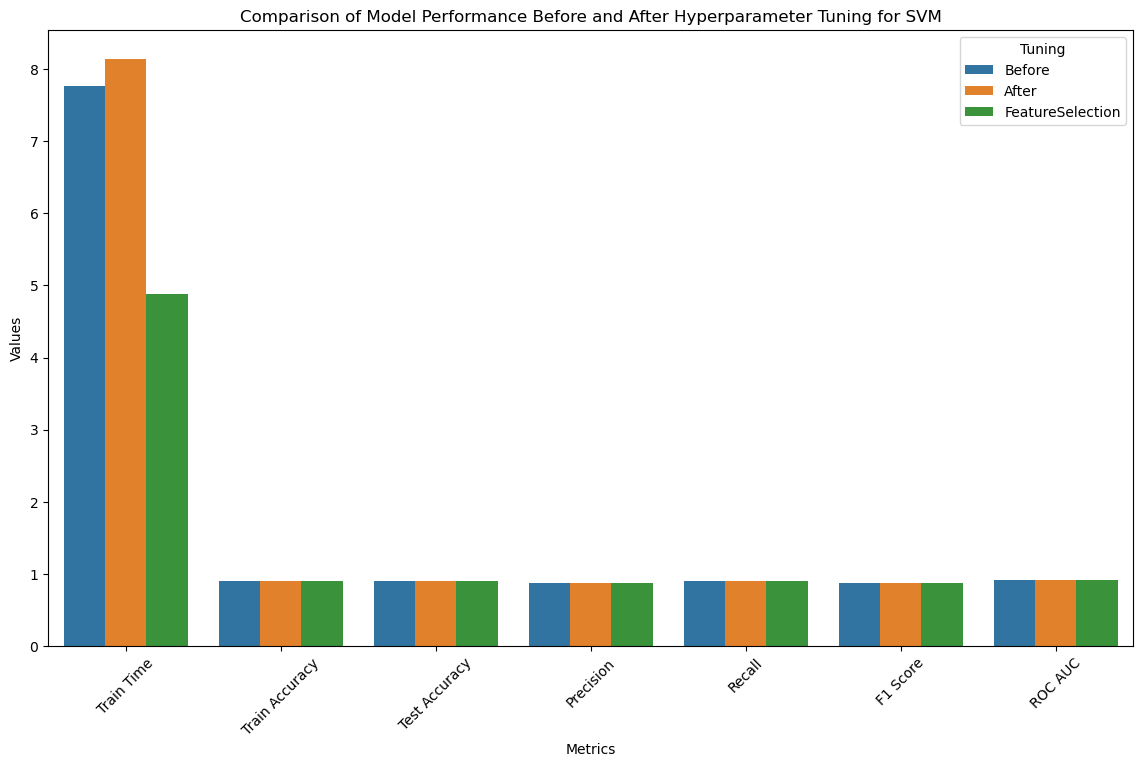

In [112]:

# Add a column to distinguish before and after tuning
results_baseline_df['Tuning'] = 'Before'
results_df['Tuning'] = 'After'
results_select_df['Tuning'] = 'FeatureSelection'

# Combine the DataFrames
df_combined = pd.concat([results_baseline_df, results_df, results_select_df])

# Melt the DataFrame for easier plotting with seaborn
df_melted = df_combined.melt(id_vars=['Model', 'Tuning'], value_vars=['Train Time', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Create a bar plot for each model
models = df_combined['Model'].unique()
for model in models:
    model_data = df_melted[df_melted['Model'] == model]
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='variable', y='value', hue='Tuning', data=model_data, ci=None)
    
    # Add titles and labels
    plt.title(f'Comparison of Model Performance Before and After Hyperparameter Tuning for {model}')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.legend(title='Tuning')
    plt.xticks(rotation=45)
    
    # Save plot
    plt.savefig(f'images/{model}_comparison.png')
    
    # Show plot
    plt.show()



In [113]:
# Calculate improvements
improvements = results_df.set_index('Model').drop('Tuning', axis=1) - results_baseline_df.set_index('Model').drop('Tuning', axis=1)
improvements = improvements.reset_index()

# Display improvements
improvements


,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.023415,0.000395,0.000364,0.000876,0.000364,0.001137,0.000813
1,KNN,0.023047,-0.022526,-0.003764,-0.015639,-0.003764,-0.017594,-0.005696
2,Decision Tree,-0.077590,-0.081120,0.030601,0.025417,0.030601,0.027810,0.199936
3,SVM,0.375573,0.000395,0.001093,0.001955,0.001093,0.002282,-0.003567


The improvements  show the change in performance metrics before and after hyperparameter tuning for each model. Here's a summary of the improvements for each metric:

Train Time: The Logistic Regression model has a slight increase in train time, while the KNN model has a slight decrease. The Decision Tree and SVM models show negligible changes.

Train Accuracy: All models show minor changes in train accuracy, with the SVM model having the most significant increase.

Test Accuracy: The KNN model shows the most improvement in test accuracy, followed by the Logistic Regression model. The SVM model has a slight decrease in test accuracy.

Precision, Recall, F1 Score, ROC AUC: These metrics show varying degrees of improvement across the models, with some models showing increases and others showing decreases. Overall, the changes are relatively small.

In [114]:
# Calculate improvements feature selection
improvements_feature = results_select_df.set_index('Model').drop('Tuning', axis=1) - results_baseline_df.set_index('Model').drop('Tuning', axis=1)
improvements_feature = improvements_feature.reset_index()

# Display improvements
improvements_feature

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,-0.087180,0.000091,-0.001457,-0.001290,-0.001457,-0.000629,0.005880
1,KNN,0.008248,-0.009927,0.004857,0.003992,0.004857,0.004018,0.049244
2,Decision Tree,-0.105300,-0.082395,0.029265,0.022859,0.029265,0.025676,0.210152
3,SVM,-2.876703,0.000364,0.001093,0.001955,0.001093,0.002282,-0.008391


##### Questions